In [ ]:
# 1) Descarga y prepara el binario de fastText y el modelo (solo una vez)
!wget -q https://github.com/facebookresearch/fastText/archive/refs/tags/v0.9.2.tar.gz -O fasttext-0.9.2.tar.gz
!tar -xzf fasttext-0.9.2.tar.gz
# Compilar (si quieres compilar desde fuente)
!apt-get update -qq && apt-get install -qq -y build-essential
!make -C fastText-0.9.2

# El binario quedará en fastText-0.9.2/fasttext
FASTTEXT_BIN = "/content/fastText-0.9.2/fasttext"  # <- ruta posible si compiló correctamente
# Si la ruta falla puedes buscar: !find /content -name fasttext -type f

# Descarga el modelo lid.176.bin (si no lo tienes)
!wget -q https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin -O /content/lid.176.bin



W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
make: Entering directory '/content/fastText-0.9.2'
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/args.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/autotune.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/matrix.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/dictionary.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/loss.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/productquantizer.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/densematrix.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/quantmatrix.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/v

In [ ]:
# 2) Procesar el DataFrame por CHUNKS sin usar fasttext Python
import os
import subprocess
from tqdm import tqdm
import pandas as pd

In [ ]:
path_clean_df = "/content/drive/MyDrive/00. Universidad/02. Analisis de Datos/evento evaluativo 4/clean_amazon_review_full.parquet"
df = pd.read_parquet(path_clean_df, engine="pyarrow")
df.head()

,rating,title,review,clean_title,clean_review
0,3,more like funchuck,Gave this to my dad for a gag gift after direc...,more like funchuck,gave this to my dad for a gag gift after direc...
1,5,Inspiring,I hope a lot of people hear this cd. We need m...,inspiring,i hope a lot of people hear this cd we need mo...
2,5,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...,the best soundtrack ever to anything,im reading a lot of reviews saying that this i...
3,4,Chrono Cross OST,The music of Yasunori Misuda is without questi...,chrono cross ost,the music of yasunori misuda is without questi...
4,5,Too good to be true,Probably the greatest soundtrack in history! U...,too good to be true,probably the greatest soundtrack in history us...


In [ ]:
OUTPUT_PARQUET = "/content/drive/MyDrive/00. Universidad/02. Analisis de Datos/evento evaluativo 4/classified_review_language_amazon_sentiment.parquet"

# Ajustes
MODEL_PATH = "/content/lid.176.bin"
FASTTEXT_PATH = "/content/fastText-0.9.2/fasttext"  # ajusta si tu binario quedó en otra ruta
CHUNK_SIZE = 100_000   # procesamos 100k filas por chunk (ajusta si quieres más/menos)
TMP_INPUT = "/content/fasttext_input.txt"
TMP_OUTPUT = "/content/fasttext_output.txt"

n = len(df)
langs = [None] * n
confs = [None] * n

# Procesar por chunks
for start in tqdm(range(0, n, CHUNK_SIZE), desc="Chunks"):
    end = min(start + CHUNK_SIZE, n)
    chunk = df['clean_review'].iloc[start:end].fillna("").astype(str).tolist()

    # 2.a) escribir chunk a archivo (una línea por título)
    with open(TMP_INPUT, "w", encoding="utf-8") as f:
        for line in chunk:
            # Escapar newlines si los hubiera
            f.write(line.replace("\n", " ") + "\n")

    # 2.b) invocar fasttext predict-prob para obtener 1 etiqueta con prob
    # Comando: fasttext predict-prob model.bin input.txt k > output.txt
    cmd = [FASTTEXT_PATH, "predict-prob", MODEL_PATH, TMP_INPUT, "1"]
    # Ejecutar y redirigir salida al archivo TMP_OUTPUT
    with open(TMP_OUTPUT, "w", encoding="utf-8") as out_f:
        subprocess.run(cmd, stdout=out_f, check=True)

    # 2.c) leer output y parsear
    # Cada línea de salida tiene formato: "__label__en 0.987654"
    with open(TMP_OUTPUT, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            parts = line.strip().split()
            if len(parts) == 2:
                label = parts[0].replace("__label__", "")
                prob = float(parts[1])
            elif len(parts) == 0:
                label = None
                prob = 0.0
            else:
                # fallback si hay espacios extra
                label = parts[0].replace("__label__", "")
                try:
                    prob = float(parts[-1])
                except:
                    prob = 0.0
            idx = start + i
            langs[idx] = label
            confs[idx] = prob

# 3) Asignar columnas al DataFrame
df['lang_detected'] = langs
df['lang_confidence'] = confs



Chunks: 100%|██████████| 37/37 [02:43<00:00,  4.41s/it]


In [ ]:
df.to_parquet(OUTPUT_PARQUET , index=False)

In [ ]:
df

,rating,title,review,clean_title,clean_review,lang_detected,lang_confidence
0,3,more like funchuck,Gave this to my dad for a gag gift after direc...,more like funchuck,gave this to my dad for a gag gift after direc...,en,0.958576
1,5,Inspiring,I hope a lot of people hear this cd. We need m...,inspiring,i hope a lot of people hear this cd we need mo...,en,0.960202
2,5,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...,the best soundtrack ever to anything,im reading a lot of reviews saying that this i...,en,0.961903
3,4,Chrono Cross OST,The music of Yasunori Misuda is without questi...,chrono cross ost,the music of yasunori misuda is without questi...,en,0.941064
4,5,Too good to be true,Probably the greatest soundtrack in history! U...,too good to be true,probably the greatest soundtrack in history us...,en,0.989173


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#top 10 idiomas mas registrados:
top_10_languages = df['lang_detected'].value_counts().head(10)
top_10_languages

,count
lang_detected,
en,3641955
es,6525
fr,684
pt,309
de,162
it,160
nl,33
pl,23
sr,17


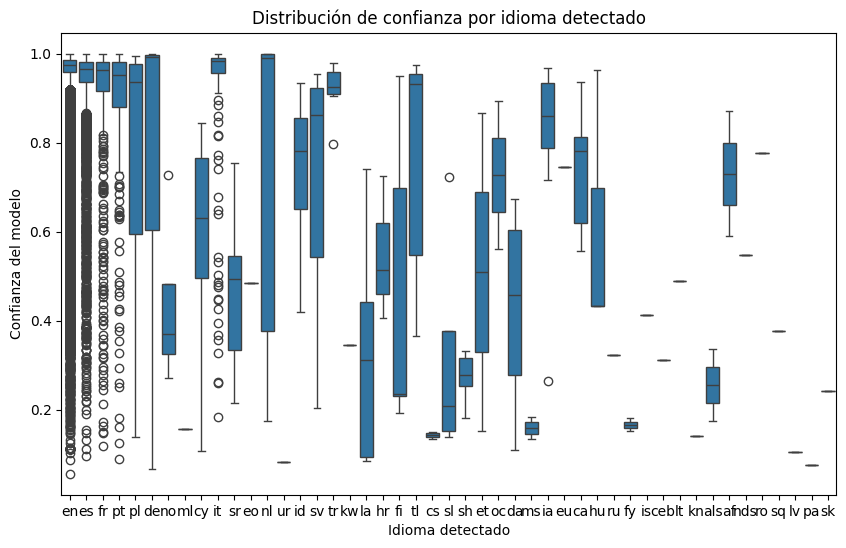

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(x='lang_detected', y='lang_confidence', data=df)
plt.title('Distribución de confianza por idioma detectado')
plt.xlabel('Idioma detectado')
plt.ylabel('Confianza del modelo')
plt.show()

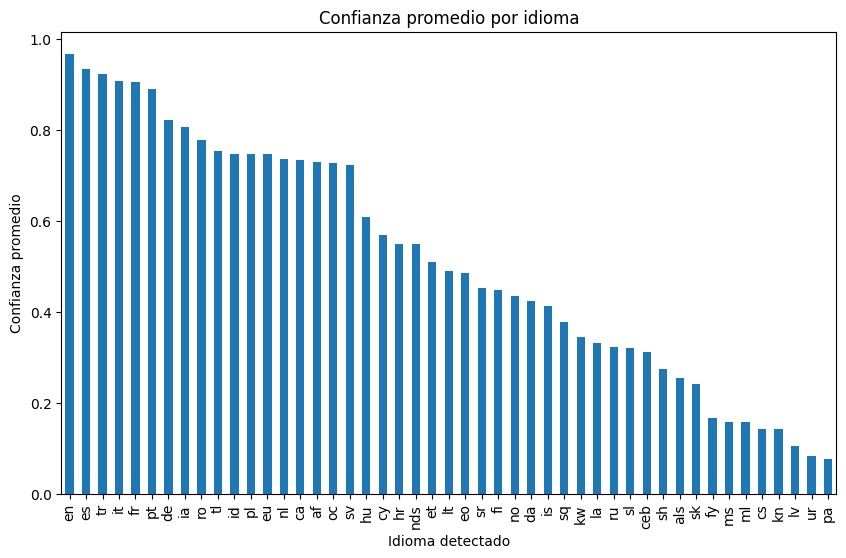

In [ ]:
confianza_media = df.groupby('lang_detected')['lang_confidence'].mean().sort_values(ascending=False)
confianza_media.plot(kind='bar', figsize=(10,6))
plt.title('Confianza promedio por idioma')
plt.xlabel('Idioma detectado')
plt.ylabel('Confianza promedio')
plt.show()


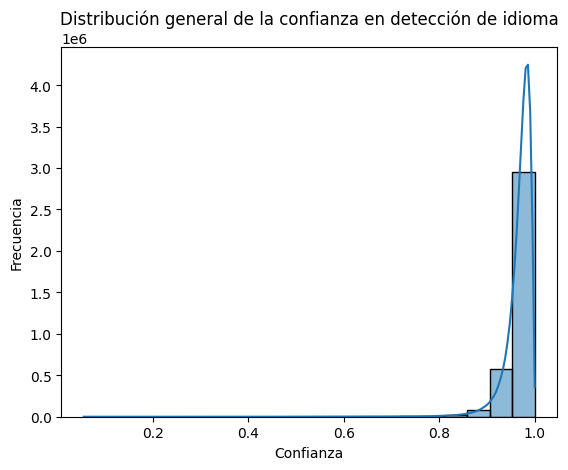

In [ ]:
sns.histplot(df['lang_confidence'], bins=20, kde=True)
plt.title('Distribución general de la confianza en detección de idioma')
plt.xlabel('Confianza')
plt.ylabel('Frecuencia')
plt.show()


In [ ]:
df_en_conf = df[(df['lang_detected'] == 'en') & (df['lang_confidence'] >= 0.8)]
df_en_conf.to_parquet(
    "/content/drive/MyDrive/00. Universidad/02. Analisis de Datos/evento evaluativo 4/en_amazon_review.parquet",
    engine="pyarrow",
    compression="snappy",
    index=False
)